# LSTM
Try sequence-of-Kmers. First try. K=2. Coding 3K-4K, A549. One round CV, 5 epoch. 62% acc.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-17 07:51:53.768540
Python 3.10.0
sklearn 1.1.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
#from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=2
EPOCHS=5
FOLDS=5   # but terminate after one
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially
MINLEN=3000

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=0
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Data Load

In [6]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-17 07:52:04.737978
Num RCI: 10338
[('ENSG00000000003', 1.08068), ('ENSG00000000419', 1.32679), ('ENSG00000000457', 0.434284)]


In [7]:
def seq_to_kmers(rna,K):
    if K!=2:
        raise Exception('So far, we only support K=2')
    # HOTS = {'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1], 'N':[0,0,0,0]}
    VALS = {'A':0, 'C':1, 'G':2, 'T':3, 'N':0}
    length = len(rna)
    vec = []
    for i in range(length-K+1):
        one_hot = 0
        for j in range(K):
            one_hot = one_hot * 4
            nextnuc = rna[i+j]
            nucval = VALS[nextnuc]
            one_hot = one_hot + nucval
        vec.append(one_hot)
    return vec
print(seq_to_kmers('AAA',2))
print(seq_to_kmers('CAT',2))
print(seq_to_kmers('TTG',2))

[0, 0]
[4, 3]
[15, 14]


In [8]:
# one hot
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                hot_vec = seq_to_kmers(seq_txt,K)
                allseq.append(hot_vec)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-11-17 07:52:04.794233
Load sequence
2022-11-17 07:52:18.789956
Num IDs: 5579
Num labels: 5579
Num counts: 5579


In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [14]:
def build_model():
    ALPHABET=4**K  # NUMBER OF DISTINCT KMERS POSSIBLE
    EMBED_DIMEN = 16 # arbitrary hyperparameter
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    # This layer automatically converts inputs to one-hot using alphabet size.
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH);
    # rnn1_layer = Bidirectional(
    # rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    rnn1_layer = LSTM(16, return_sequences=True) 
    # rnn2_layer = LSTM(16, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = Dense(8,activation='sigmoid',dtype=dt)
    # dropout1_layer = Dropout(0.25)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    #rnn.add(dropout1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [11]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-11-17 07:52:18.850892


2022-11-17 07:52:18.855565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3999, 16)          256       
                                                                 
 lstm (LSTM)                 (None, 3999, 16)          2112      
                                                                 
 dense (Dense)               (None, 3999, 8)           136       
                                                                 
 dense_1 (Dense)             (None, 3999, 1)           9         
                                                                 
Total params: 2,513
Trainable params: 2,513
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
        
        break  # just do one round!
        
    print()
    return cv_scores
print(datetime.now())

2022-11-17 07:52:19.314634


Issues to address:

Reduce dtype to int8?
Call arguments received by layer "sequential" "                 f"(type Sequential):
inputs=tf.Tensor(shape=(None, 4000, 4), dtype=int32)

The genes were shuffled but the transcripts were not.  
That could retard training.

Loading sequence takes minutes. Save one-hot dataset to binary file. 

Loading sequence takes RAM. A numpy array of one-hot might require less RAM. Write a just-in-time loader.

Accuracy goes down at the start of each epoch. This could mean that the data are not shuffled sufficiently.

2022-11-17 07:52:19.329190
2022-11-17 07:52:19.330548
splitting
Fold 1
Train sizes (4473, 3999) (4473, 1)
Valid sizes (1106, 3999) (1106, 1)
Train set ones/size 1989 / 4473
Valid set ones/size 487 / 1106
BUILD MODEL
COMPILE
FIT
2022-11-17 07:52:22.076494
Epoch 1/5
140/140 [==============================] - 339s 2s/step - loss: 0.6751 - accuracy: 0.5835 - val_loss: 0.6417 - val_accuracy: 0.6549
Epoch 2/5
140/140 [==============================] - 323s 2s/step - loss: 0.6336 - accuracy: 0.6540 - val_loss: 0.6351 - val_accuracy: 0.6665
Epoch 3/5
140/140 [==============================] - 322s 2s/step - loss: 0.6301 - accuracy: 0.6460 - val_loss: 0.6235 - val_accuracy: 0.6665
Epoch 4/5
140/140 [==============================] - 322s 2s/step - loss: 0.6144 - accuracy: 0.6664 - val_loss: 0.6345 - val_accuracy: 0.6330
Epoch 5/5
140/140 [==============================] - 323s 2s/step - loss: 0.6504 - accuracy: 0.6374 - val_loss: 0.6656 - val_accuracy: 0.6200


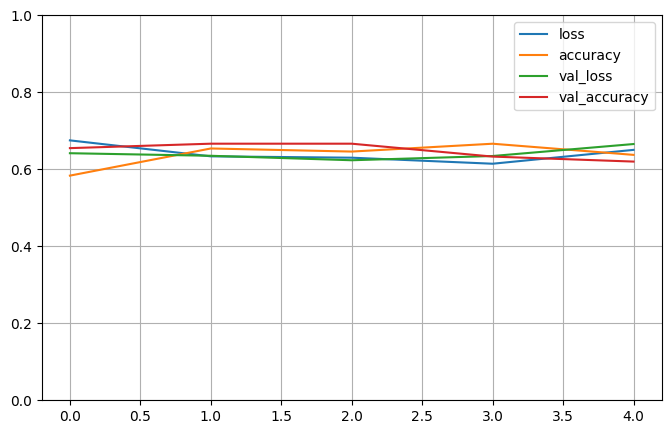

Compute valiation accuracy
2022-11-17 08:19:30.852902
accuracy: 62.00%
2022-11-17 08:19:38.964929

Cross validation acc mean 62.00% (+/- 0.00%)
2022-11-17 08:19:38.967704


In [13]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())